In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve
import numpy as np
import pandas as pd
import os
import sys

import equiboots as eqb

### Fetching Dataset

In [2]:
adult_x = pd.read_parquet("../data/processed/X.parquet")
adult_y = pd.read_parquet("../data/processed/y_income.parquet")

In [3]:
from adult_income.functions import find_best_model, mlflow_load_model

In [4]:
def return_best_model(outcome, metric, mlruns_location):

    outcome = "income"
    experiment_name = outcome + "_model"

    run_name, estimator_name = find_best_model(
        experiment_name, metric, mlruns_location=mlruns_location
    )

    model_name = f"{estimator_name}_{outcome}"
    best_model = mlflow_load_model(
        experiment_name, run_name, model_name, mlruns_location=mlruns_location
    )
    return best_model

In [5]:
best_model = return_best_model("income", "valid Average Precision", "../mlruns/models/")


test_x, test_y = best_model.get_test_data(adult_x, adult_y)

Best Run ID: c8e873695f3649209c7d7ffc70ac537f, Best valid Average Precision: 0.762


In [6]:
y_pred = best_model.predict(test_x)
y_prob = best_model.predict_proba(test_x)[:, 1]
y_true = test_y.to_numpy().ravel()
fairness_df = test_x[["race", "sex"]]

/home/afunnell/miniconda3/envs/adultincome/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:23:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [7]:
fairness_df = fairness_df.reset_index()

In [8]:
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

Groups created


In [9]:
y_true

array([1, 0, 0, ..., 1, 0, 0])

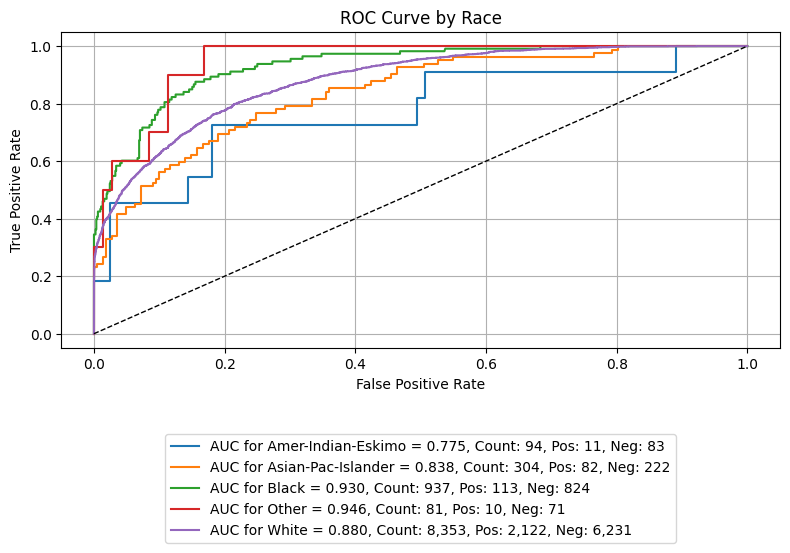

In [10]:
eqb.eq_plot_roc_auc(
    data=sliced_data,
    title="ROC Curve by Race",
    decimal_places=3,
)

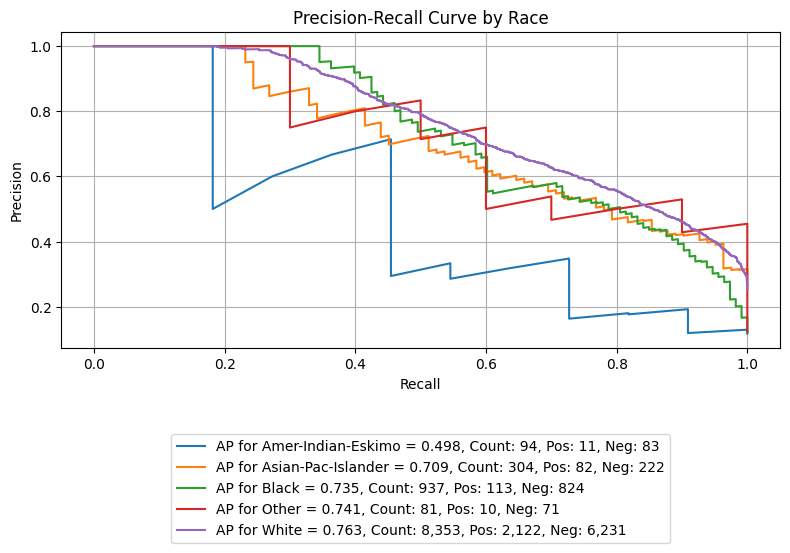

In [11]:
# Precision-Recall plot
fig2 = eqb.eq_plot_precision_recall(
    data=sliced_data,
    title="Precision-Recall Curve by Race",
    decimal_places=3,
    dpi=100,
)

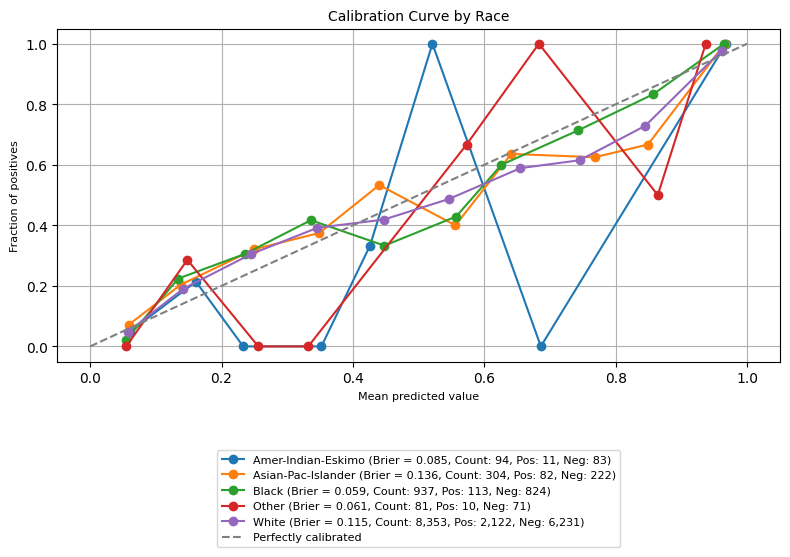

In [12]:
# Calibration plot
fig3 = eqb.eq_calibration_curve_plot(
    data=sliced_data,
    n_bins=10,
    title="Calibration Curve by Race",
    tick_fontsize=8,
    decimal_places=3,
)
fig3

### Bootstrapped Graphs - Stratified

In [13]:
eq2 = eqb.EquiBoots(
    y_true,
    y_prob,
    y_pred,
    fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["White", "Male"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=10,
    boot_sample_size=2000,
    balanced=False,
)

# Set seeds
int_list = np.linspace(200, 300, num=10, dtype=int).tolist()


eq2.set_fix_seeds(int_list)

print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

data = eq2.slicer("race")
race_metrics = eq2.get_metrics(data)

dispa = eq2.calculate_disparities(race_metrics, "race")

melted = pd.DataFrame(dispa).melt()
df = melted["value"].apply(pd.Series).assign(attribute_value=melted["variable"])

seeds [200, 211, 222, 233, 244, 255, 266, 277, 288, 300]


Bootstrapping iterations: 100%|██████████| 10/10 [00:00<00:00, 171.18it/s]

Groups created



/home/afunnell/miniconda3/envs/adultincome/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/afunnell/miniconda3/envs/adultincome/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/afunnell/miniconda3/envs/adultincome/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

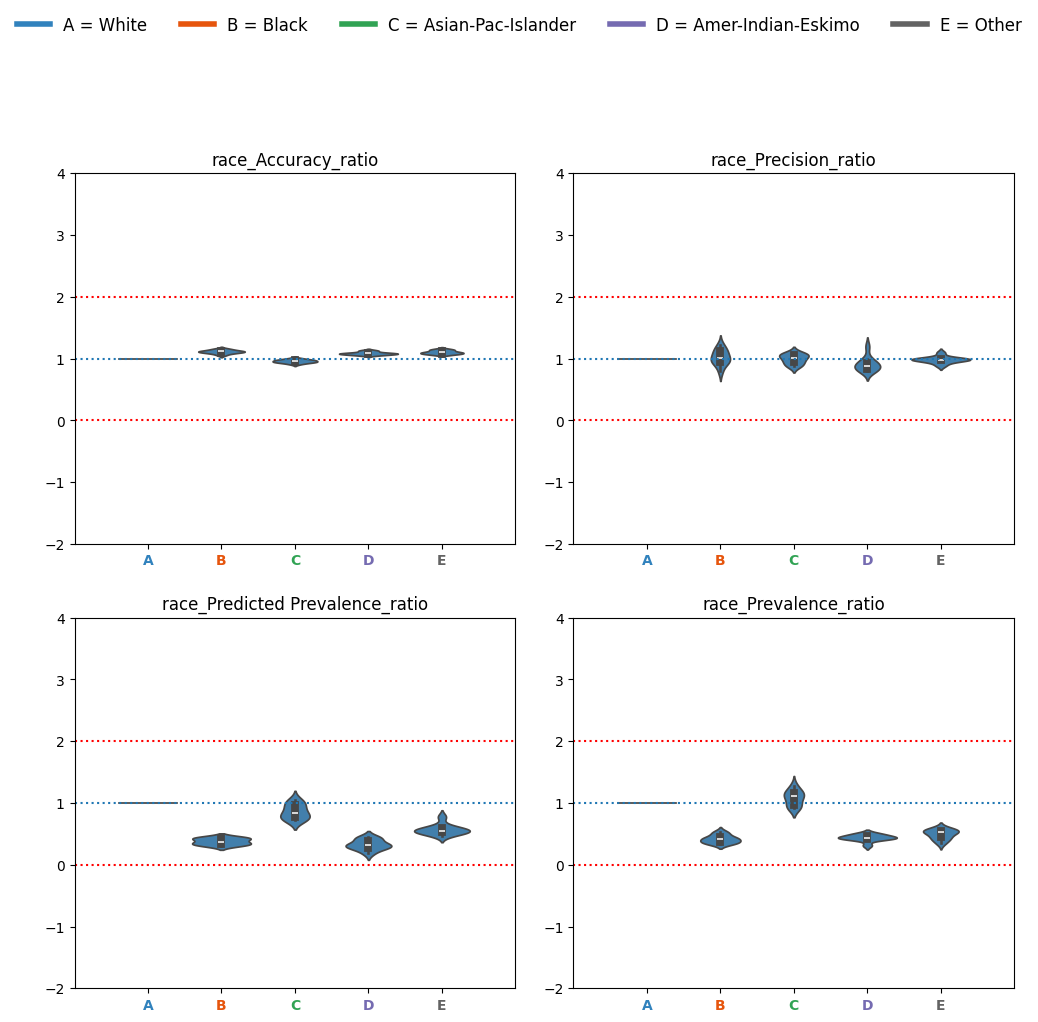

In [39]:
eqb.eq_disparity_metrics_plot(
    dispa,
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Predicted Prevalence_ratio",
        "Prevalence_ratio",
    ],
    name="race",
    categories="all",
    figsize=(10, 9),
    strict_layout=False,
    plot_kind="violinplot",
)

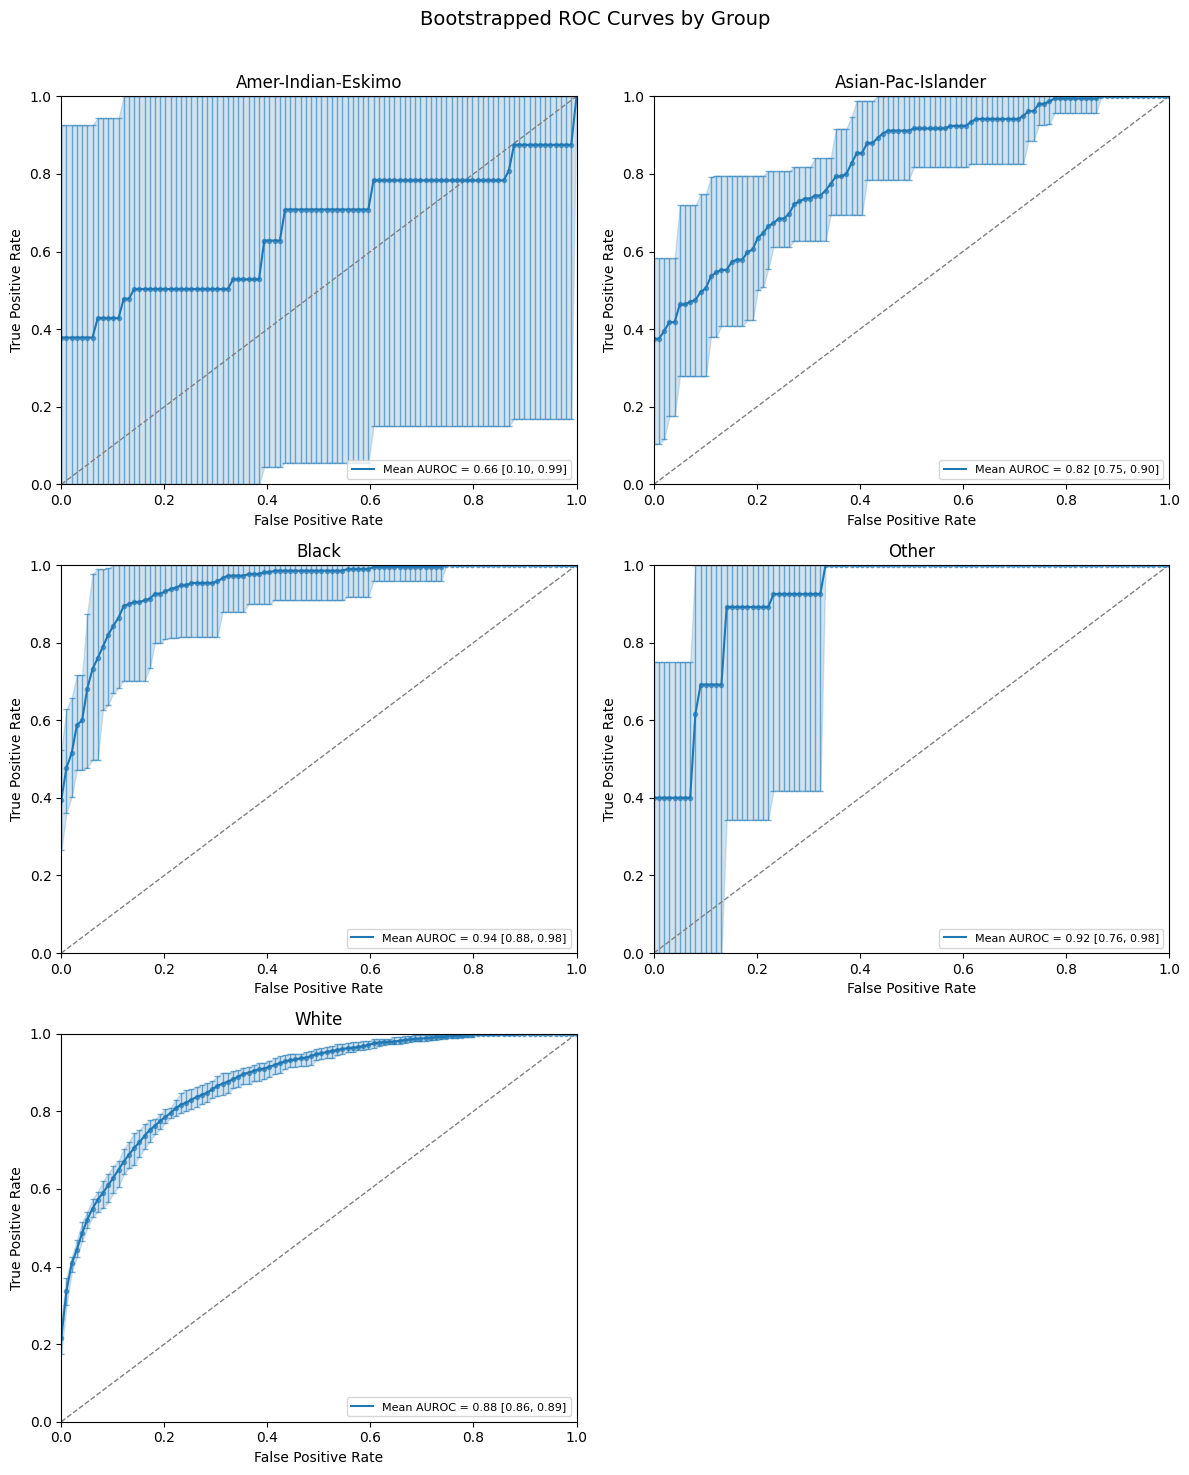

In [15]:
sliced = eq2.slicer(slicing_var="race")
eqb.eq_plot_bootstrapped_roc_curves(sliced, bar_every=100)

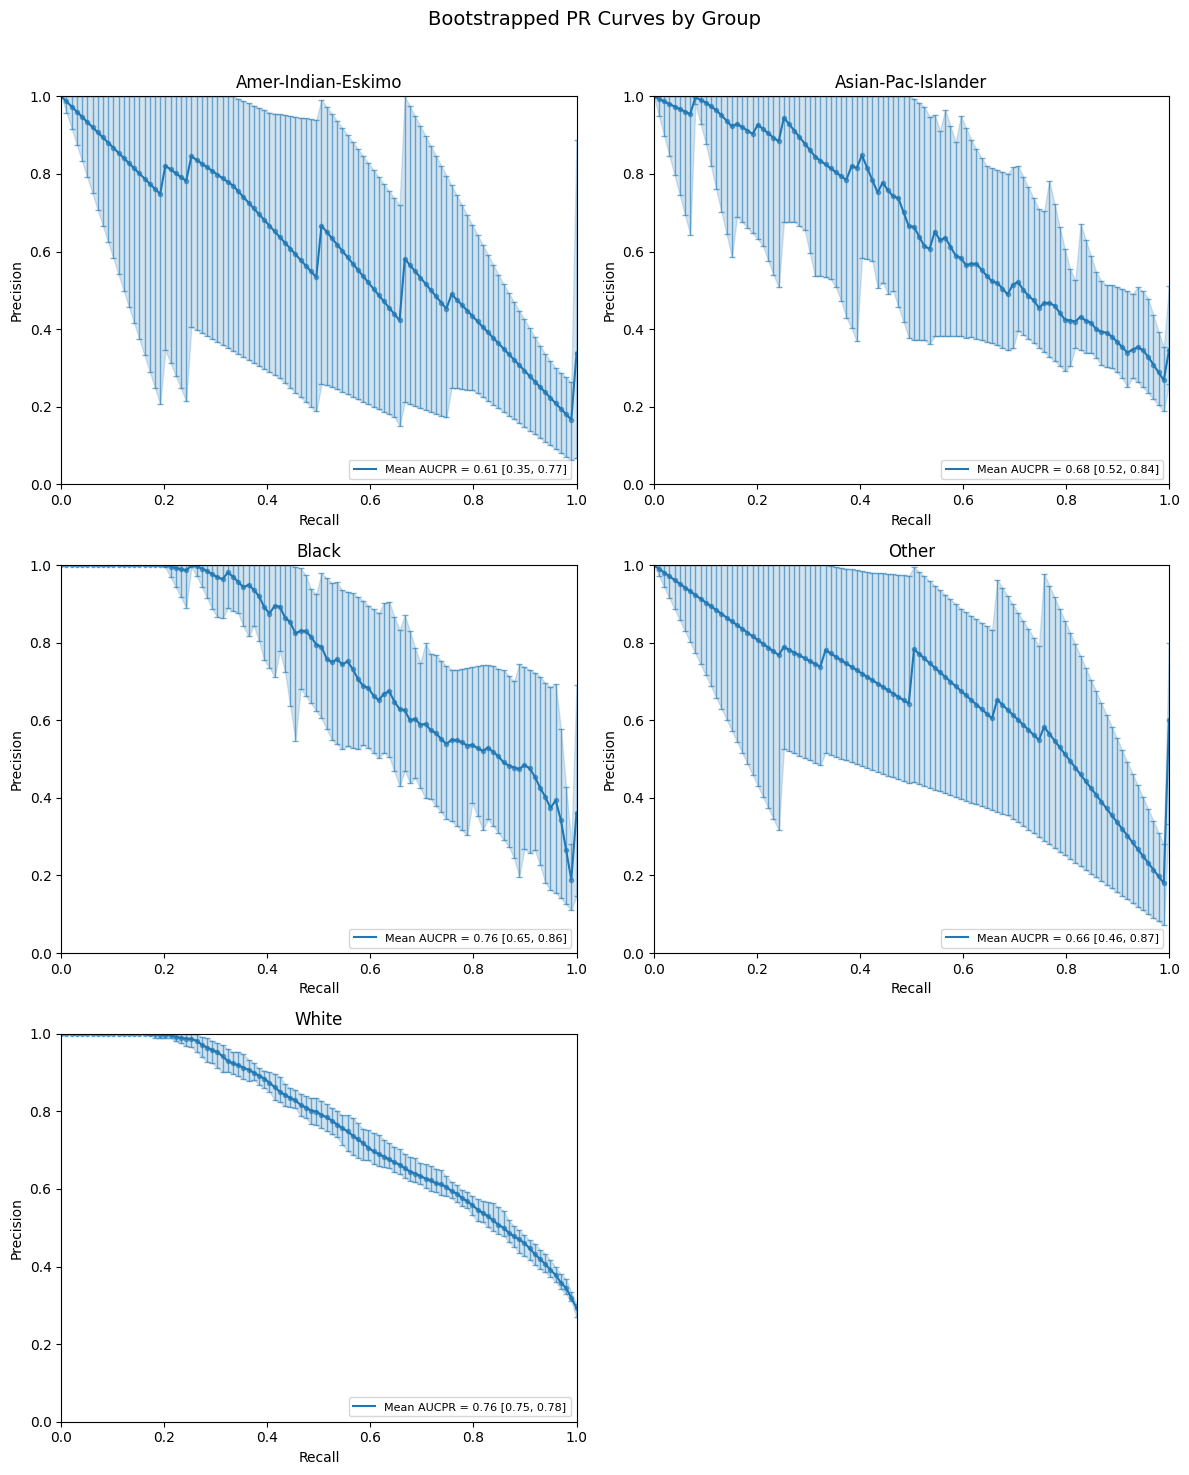

In [16]:
eqb.eq_plot_bootstrapped_pr_curves(sliced, bar_every=100)

/home/afunnell/miniconda3/envs/adultincome/lib/python3.11/site-packages/equiboots/plots.py:850: RuntimeWarning: Mean of empty slice
  mean_cal = np.nanmean(cal_array, axis=0)
/home/afunnell/miniconda3/envs/adultincome/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


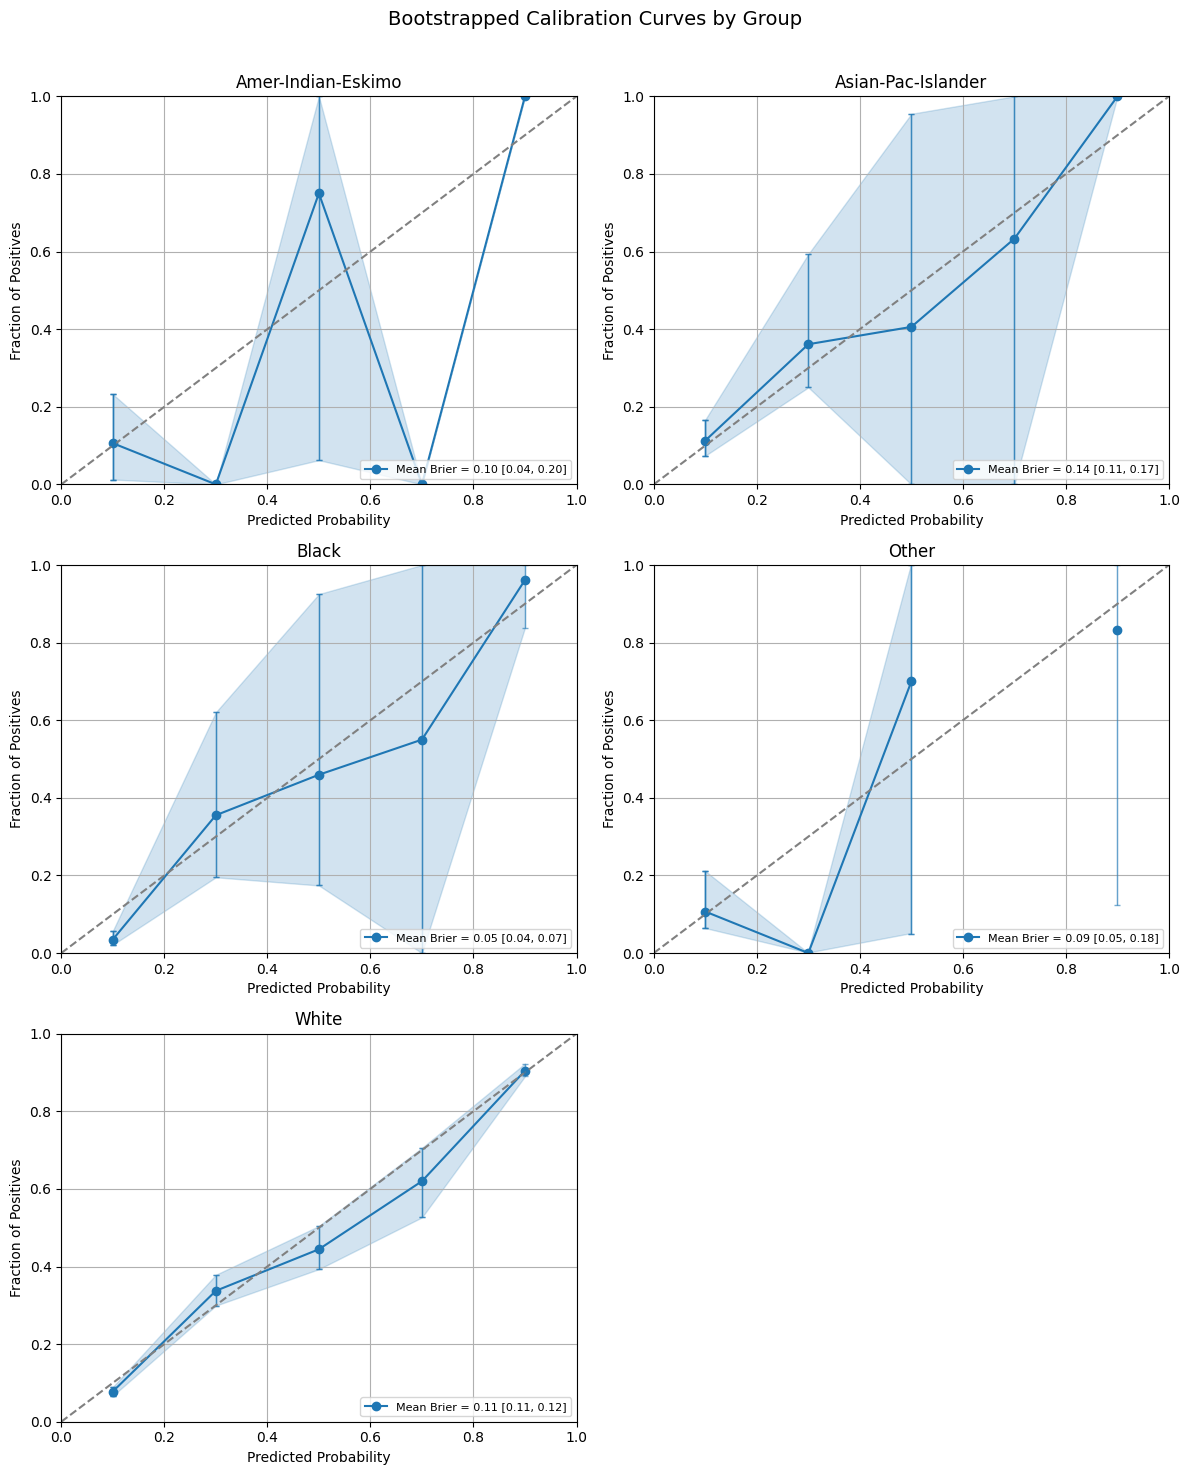

In [17]:
eqb.eq_plot_bootstrapped_calibration_curves(sliced, n_bins=5)

### Bootstrapped Graphs - Balanced

In [18]:
eq2 = eqb.EquiBoots(
    y_true,
    y_prob,
    y_pred,
    fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["White", "Male"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=10,
    boot_sample_size=2000,
    balanced=True,
)

# Set seeds
int_list = np.linspace(200, 300, num=10, dtype=int).tolist()


eq2.set_fix_seeds(int_list)

print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

data = eq2.slicer("race")
race_metrics = eq2.get_metrics(data)

dispa = eq2.calculate_disparities(race_metrics, "race")

melted = pd.DataFrame(dispa).melt()
df = melted["value"].apply(pd.Series).assign(attribute_value=melted["variable"])

seeds [200, 211, 222, 233, 244, 255, 266, 277, 288, 300]


Bootstrapping iterations: 100%|██████████| 10/10 [00:00<00:00, 170.02it/s]

Groups created


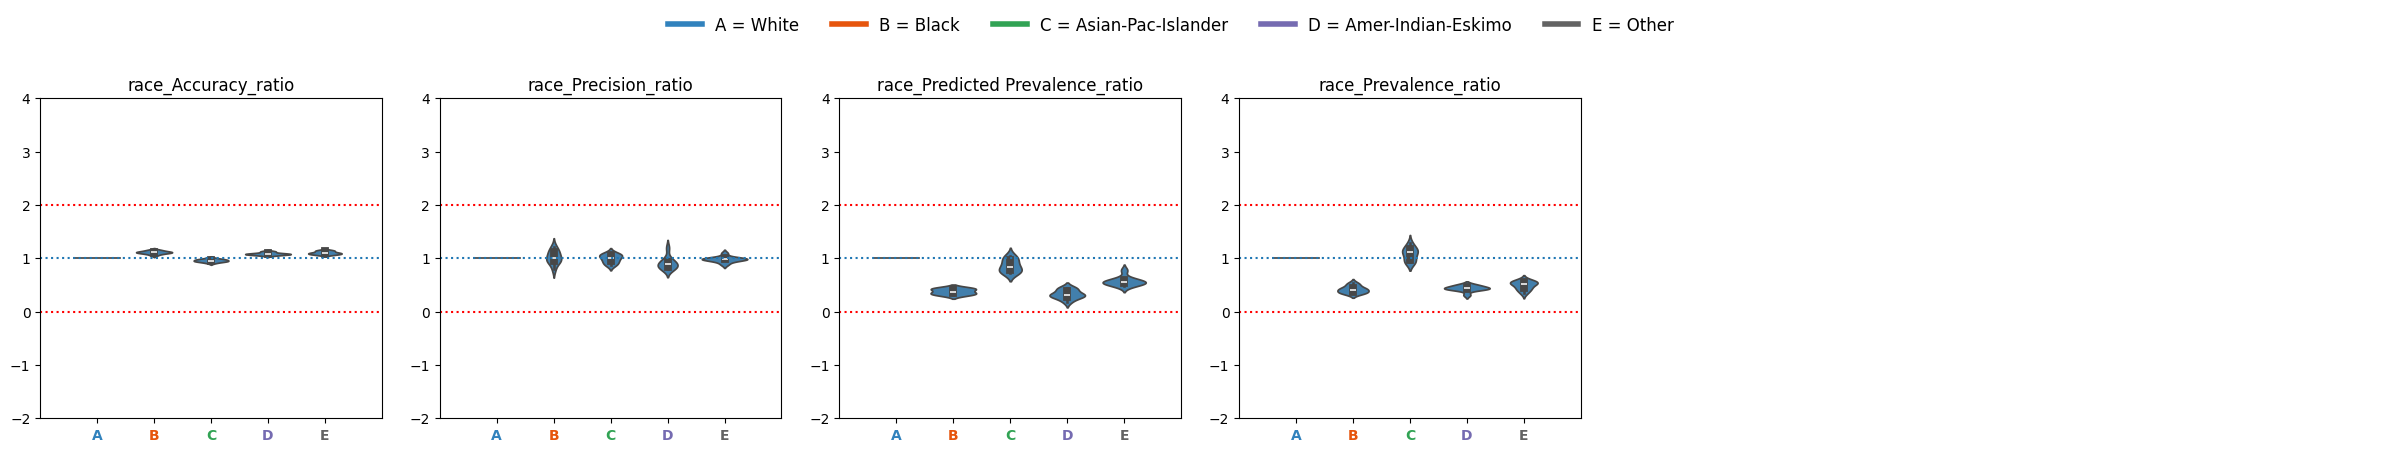

In [33]:
eqb.eq_disparity_metrics_plot(
    dispa,
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Predicted Prevalence_ratio",
        "Prevalence_ratio",
    ],
    name="race",
    categories="all",
    # figsize=(20, 5),
    # strict_layout=False,
    plot_kind="violinplot",
)

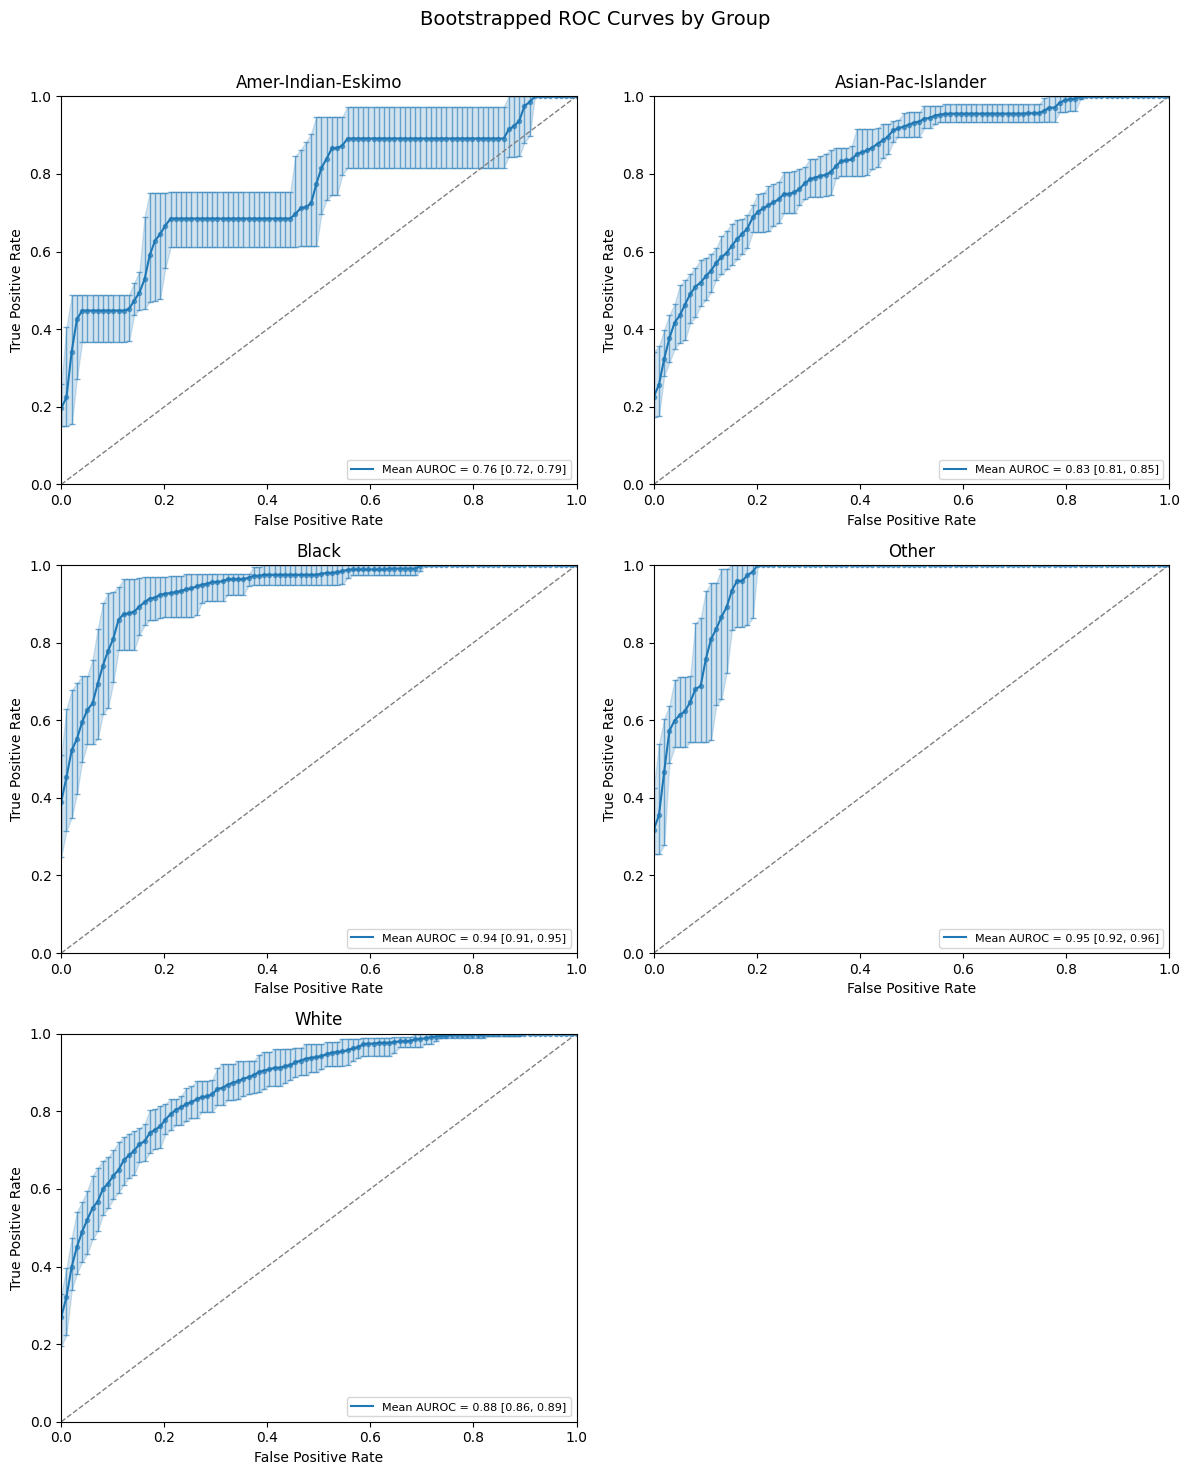

In [20]:
sliced = eq2.slicer(slicing_var="race")
eqb.eq_plot_bootstrapped_roc_curves(sliced, bar_every=100)

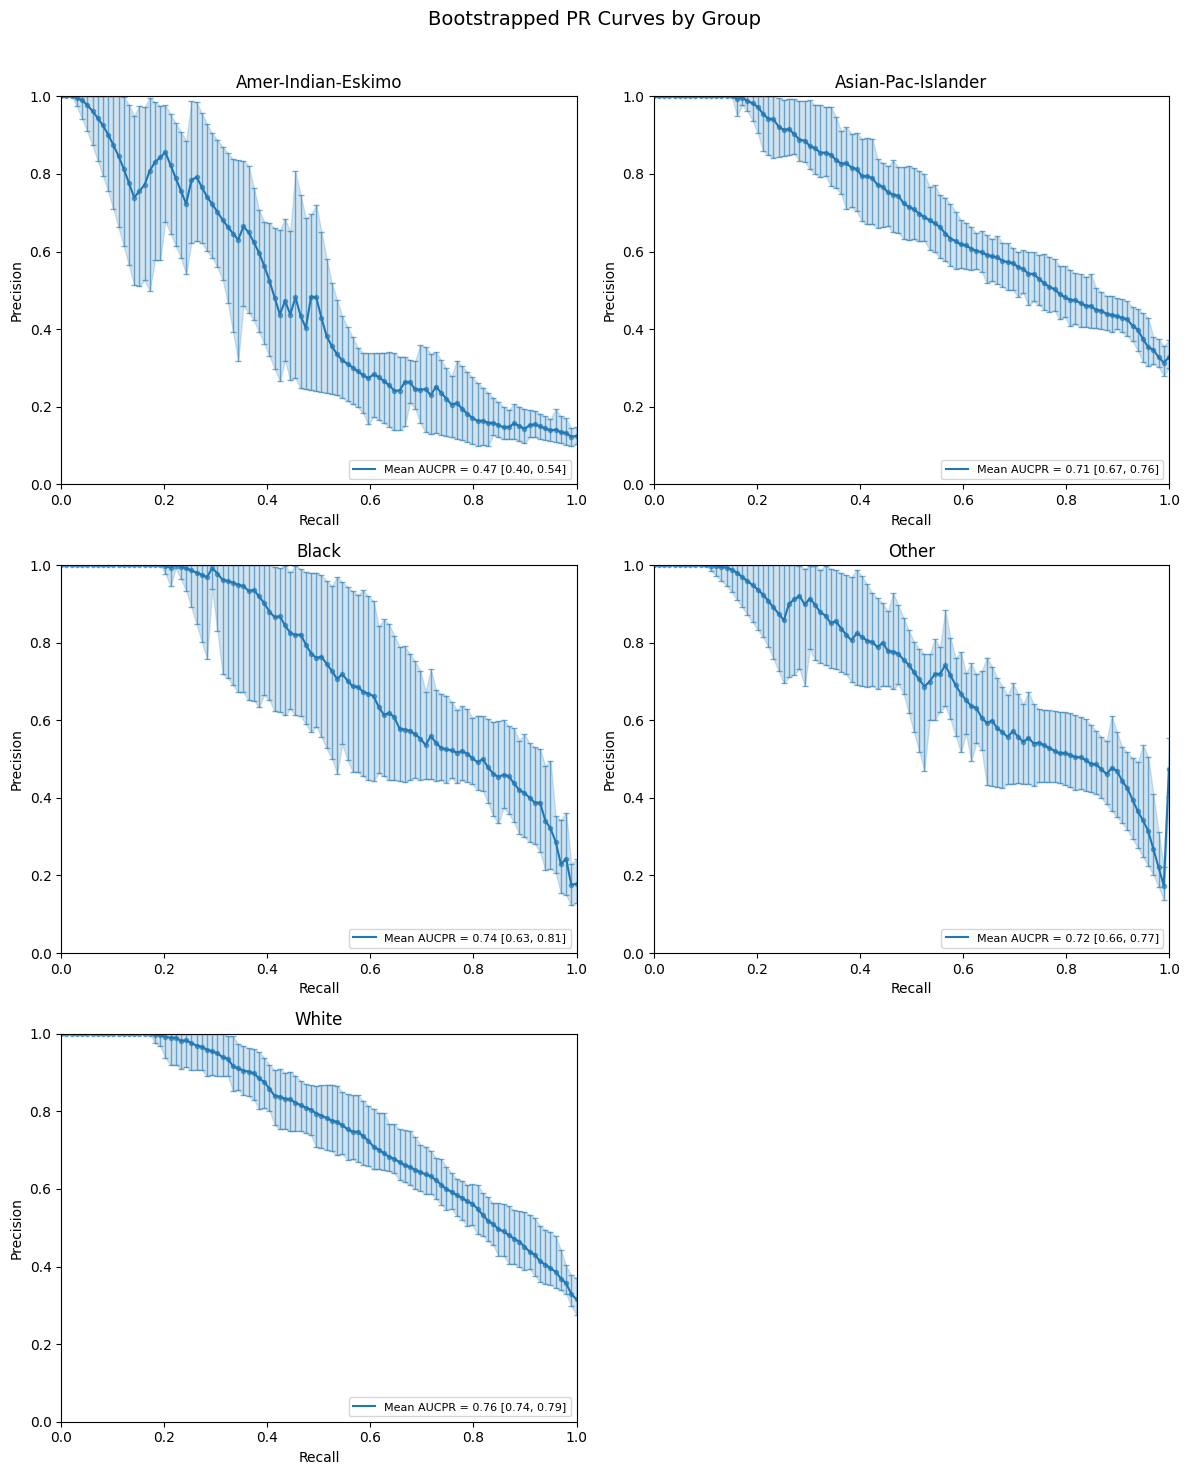

In [21]:
eqb.eq_plot_bootstrapped_pr_curves(sliced, bar_every=100)

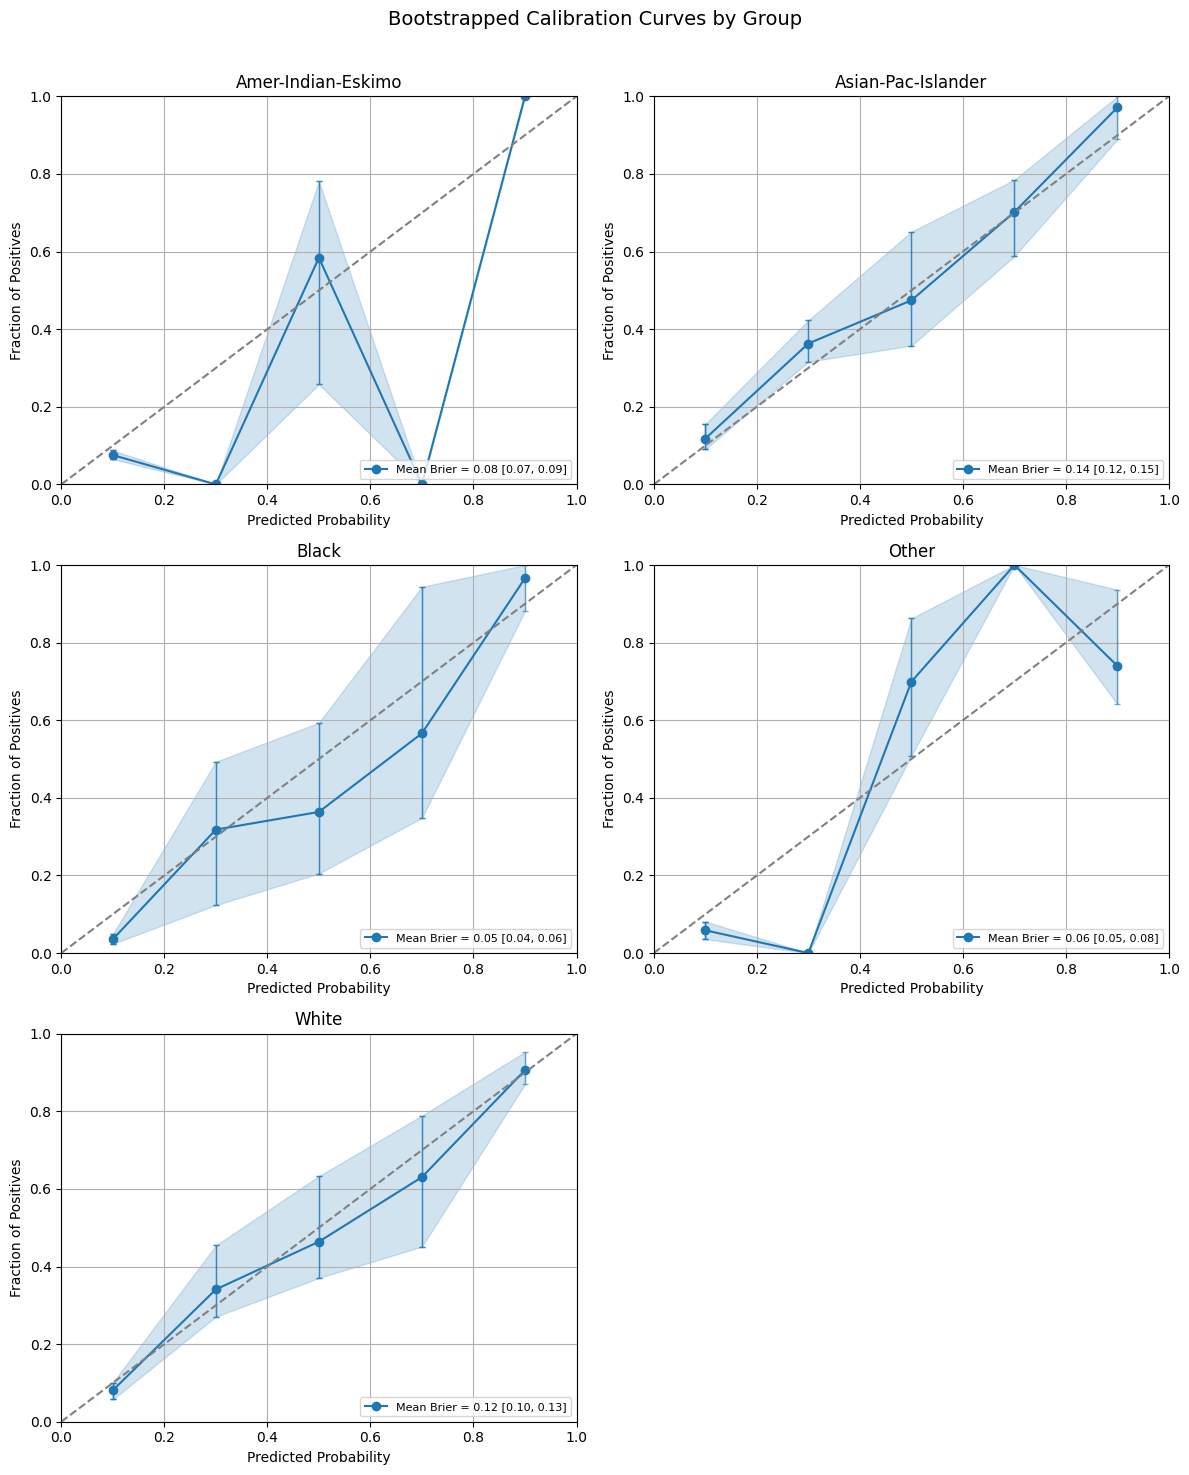

In [22]:
eqb.eq_plot_bootstrapped_calibration_curves(sliced, n_bins=5)